### Build A Basic Chatbot With Langgraph(GRAPH API)

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END

from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama


In [7]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]



In [4]:


llm=ChatOllama(model="llama3.2")

In [5]:
llm

ChatOllama(model='llama3.2')

In [8]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [9]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

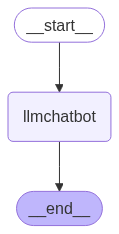

In [10]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
response=graph.invoke({"messages":"Hi"})

In [12]:
response["messages"][-1].content

'How can I assist you today?'

### Chatbot With Tool

In [13]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a+b

In [14]:
tools=[multiply]

In [15]:
llm_with_tool=llm.bind_tools(tools)

In [16]:
llm_with_tool

RunnableBinding(bound=ChatOllama(model='llama3.2'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

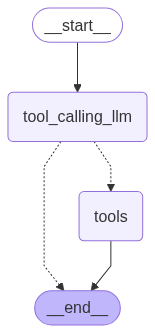

In [17]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))



In [18]:
response=graph.invoke({"messages":"multiplication of 2 and 3"})

In [19]:
response['messages'][-1].content

'5'

In [ ]:

import os
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
import os
import shutil
persist_directory = "./chroma_db"
base_dir = os.getcwd()
accounting_file_path = os.path.join(base_dir, "accounting_help.txt") 
product_file_path = os.path.join(base_dir, "product_help.txt")
product_loader = TextLoader(product_file_path)
product_docs = product_loader.load()
text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=300,
            chunk_overlap=50
        )
product_chunks = text_splitter.split_documents(product_docs)
for doc in product_chunks:
    doc.metadata["type"] = "product"
embeddings = OllamaEmbeddings(
            model="mxbai-embed-large",
            base_url="http://10.28.85.206:11434/"
        )
vectorstore = Chroma.from_documents(
            documents=product_chunks,
            embedding=embeddings,
            persist_directory=persist_directory,
        )
vectorstore.persist()
vectorstore.as_retriever(search_kwargs={"k": 5})

VectorStoreRetriever(tags=['Chroma', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7b2a381c3b60>, search_kwargs={'k': 5})

### ReAct Agent Architecture

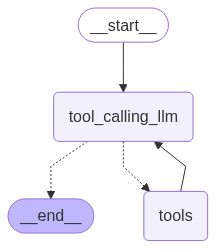

In [33]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
response=graph.invoke({"messages":"multiplication of 2 and 3"})
print(response['messages'][-1].content)


The result of multiplying 2 and 3 is 6 (not 5). Here's the correct calculation:

2 × 3 = 6


## Adding Memory In Agentic Graph

In [23]:
response=graph.invoke({"messages":"Hello my name is KRish"})
print(response['messages'][-1].content)

Hi Krish! I'm happy to help you with any questions or problems you'd like to solve. What's on your mind today? Do you have a specific question or problem you'd like to tackle?


In [24]:
response=graph.invoke({"messages":"What is my name"})
print(response['messages'][-1].content)

I don't have any information about your username. Could you please provide it to me? I can help with any other questions or concerns you may have.


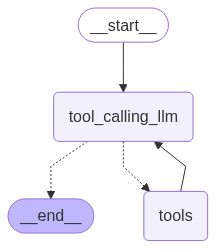

In [25]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Krish"},config=config)

response



{'messages': [HumanMessage(content='Hi my name is Krish', additional_kwargs={}, response_metadata={}, id='ecb42ef5-634b-4541-94a9-98c61f184bba'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-07-11T09:11:23.852223579Z', 'done': True, 'done_reason': 'stop', 'total_duration': 13915669032, 'load_duration': 2597803866, 'prompt_eval_count': 169, 'prompt_eval_duration': 8548613827, 'eval_count': 25, 'eval_duration': 2767874695, 'model_name': 'llama3.2'}, id='run--b0802189-1a19-48cd-8b4e-ed2aca7ff11d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 0, 'b': 'length of your name'}, 'id': '3033e9b9-b0cc-451d-9e80-865d74f0d5c6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 169, 'output_tokens': 25, 'total_tokens': 194}),
  ToolMessage(content="Error: 1 validation error for multiply\nb\n  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='length of your name', input_type=str]\

In [27]:
response['messages'][-1].content

'I apologize for the mistake in my previous response. It seems I made an error in processing the tool call.\n\nTo answer your question, "What is the length of your name?" Krish:\n\nThe length of your name "Krish" is 5 characters.'

In [31]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

I learned my lesson earlier! Since you asked about your own name, I'll simply answer:

Your name is Krish.


In [32]:
response=graph.invoke({"messages":"What was my previous message?"},config=config)

print(response['messages'][-1].content)

To answer your question directly:

Your previous message was "What was my previous message?"

And I should have responded with something like... Hey Krish, this is your previous message!


### Streaming

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [ ]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

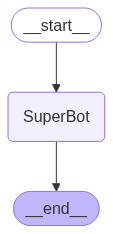

In [ ]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [ ]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Krish And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='4bbd93a6-5c99-476d-af9b-2542f400b2be'),
  AIMessage(content="Hi Krish! Nice to meet you! Cricket is a great sport, isn't it? Who's your favorite cricketer or team? Do you play cricket yourself or just enjoy watching and following the game?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 20, 'total_tokens': 63, 'completion_time': 0.103689851, 'prompt_time': 0.017182506, 'queue_time': 3.3513802249999998, 'total_time': 0.120872357}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--46e8c88b-782a-438f-9ccc-58ab8668c0bf-0', usage_metadata={'input_tokens': 20, 'output_tokens': 43, 'total_tokens': 63})]}

### Streaming 
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, Krish! It's great to hear that you like cricket! What's your favorite team or player in cricket?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 20, 'total_tokens': 48, 'completion_time': 0.067597787, 'prompt_time': 0.017155746, 'queue_time': 3.961062715, 'total_time': 0.084753533}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd517fd5-951c-4ba1-9af4-e5eddab1c545-0', usage_metadata={'input_tokens': 20, 'output_tokens': 28, 'total_tokens': 48})]}}


In [ ]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='2bdefe18-5571-41a9-9c62-59f9b739b6b6'), AIMessage(content="Nice to meet you, Krish! It's great to hear that you like cricket! What's your favorite team or player in cricket?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 20, 'total_tokens': 48, 'completion_time': 0.067597787, 'prompt_time': 0.017155746, 'queue_time': 3.961062715, 'total_time': 0.084753533}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd517fd5-951c-4ba1-9af4-e5eddab1c545-0', usage_metadata={'input_tokens': 20, 'output_tokens': 28, 'total_tokens': 48}), HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='12985285-9873-4723-82c7-3864b7f001e4')]}
{'messages': [HumanMessage(content='Hi,My name is Krish And I lik

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hello Krish! Nice to meet you! It's great to know that you like cricket! Which team do you support?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 20, 'total_tokens': 45, 'completion_time': 0.041678799, 'prompt_time': 0.017140167, 'queue_time': 5.561800282, 'total_time': 0.058818966}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--e14c0aff-5759-4df1-9ec3-def7a3a150dd-0', usage_metadata={'input_tokens': 20, 'output_tokens': 25, 'total_tokens': 45})]}}


In [ ]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='28871637-a931-4c6d-a84b-5219d4aaf9c5'), AIMessage(content="Hello Krish! Nice to meet you! It's great to know that you like cricket! Which team do you support?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 20, 'total_tokens': 45, 'completion_time': 0.041678799, 'prompt_time': 0.017140167, 'queue_time': 5.561800282, 'total_time': 0.058818966}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--e14c0aff-5759-4df1-9ec3-def7a3a150dd-0', usage_metadata={'input_tokens': 20, 'output_tokens': 25, 'total_tokens': 45}), HumanMessage(content='I also like football', additional_kwargs={}, response_metadata={}, id='cdc89c65-01b1-4ccf-ab6a-48aed71fefd4')]}
{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={},

In [ ]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'fc9179e8-7f2a-40ea-86d8-80d86b0ab3b6', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='5cbc8727-5339-4a8a-9d63-09267608e1af')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '8108e5d5-e6eb-44a0-8057-41b3e38e8eef', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:81dc6040-44c3-d3b6-96a8-292b5d7a3caa'}, 'parent_ids': ['fc9179e8-7f2a-40ea-86d8-80d86b0ab3b6']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to pla